In [56]:
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch import Tensor
from contextlib import nullcontext

import matplotlib.pyplot as plt

## Data

We model daily snow water equivalent $S$ as a function of meteorological variables $X$ (air temperature $T$, precipitation $p$, and solar radiation $r$). We deal with time series and model $S_t$ at time $t$ as a function of current and $k$ past observations of $X$:

$S = f(X_{t-k}, \ldots, X_{t-1}, X_{t})$

We use different modeling approaches:

* A long short-term memory (LSTM) model
* A hybrid model with a feedforward neural network
* A hybrid model with an LSTM


In [57]:
# Load the data.

ds = xr.open_dataset('./data/era_swe.nc')
ds['tair'].attrs['long_name'] = 'Air temperature at 2m'
ds['tair'].attrs['units'] = '°C'
ds['swe'].attrs['long_name'] = 'Snow water equivalent'
ds['swe'].attrs['units'] = 'mm'
ds

<xarray.Dataset>
Dimensions:    (time: 8036, longitude: 40, latitude: 40)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T00:00:00.000040 ... 2021-12-3...
  * longitude  (longitude) float64 60.12 60.38 60.62 60.88 ... 69.38 69.62 69.88
  * latitude   (latitude) float64 49.88 49.62 49.38 49.12 ... 40.62 40.38 40.12
Data variables:
    tair       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    swe        (time, latitude, longitude) float32 ...
    ssrd       (time, latitude, longitude) float32 ...
    mask       (latitude, longitude) bool ...

We visualize one time slice of each variable:

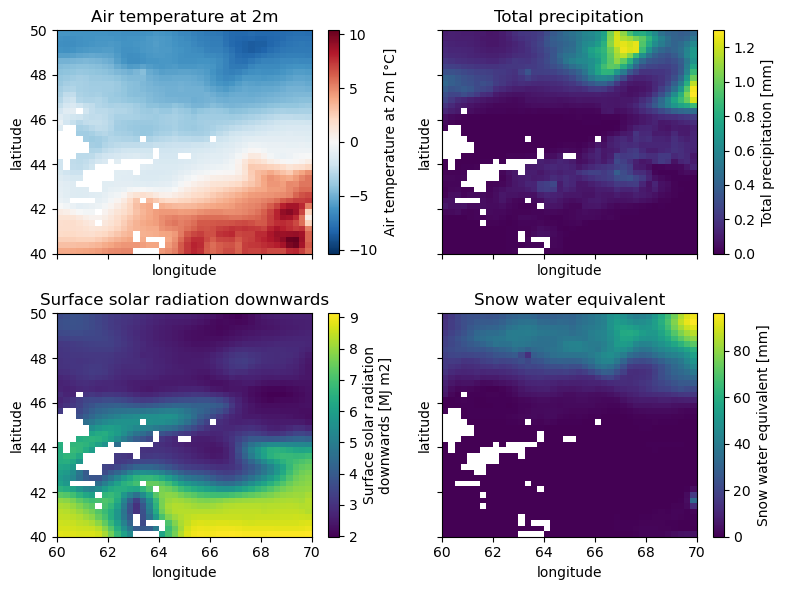

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

for i, var in enumerate(['tair', 'tp', 'ssrd', 'swe']):
    ax = axes.flat[i]

    ds[var].isel(time=0).plot(ax=ax)

    ax.set_title(ds[var].attrs['long_name'])

fig.tight_layout()
fig.savefig('./imgs/variables_map.png', dpi=300, transparent=True)

...and a few time-series for a subset of the pixels:

/var/folders/c2/2yf5xr0d17ndbz5gsnqw1jpw0000gp/T/ipykernel_30372/1645347550.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


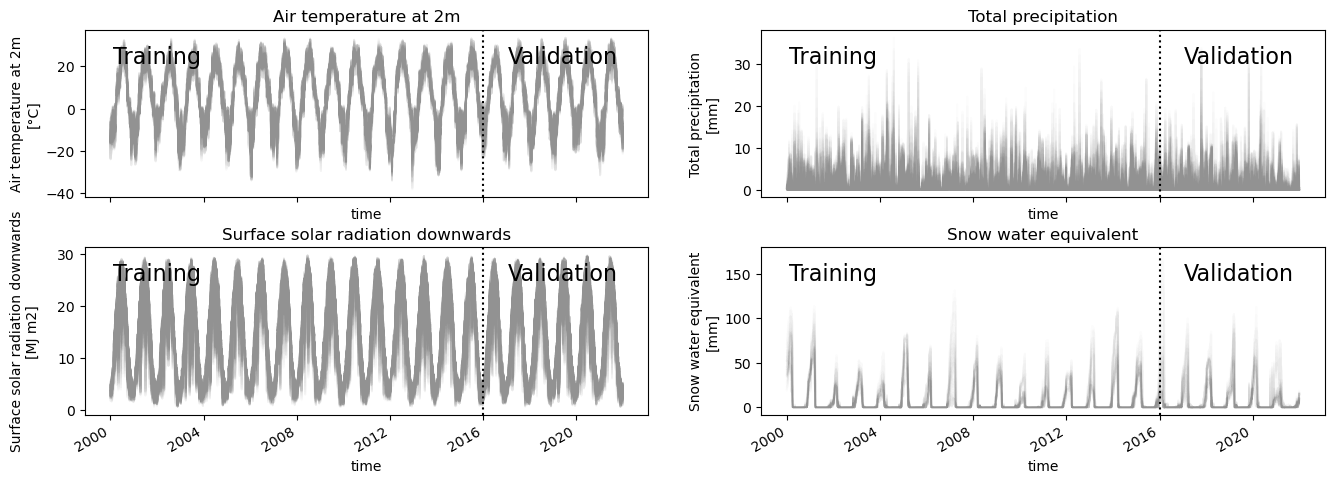

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(16, 5), sharex=True, gridspec_kw={'hspace': 0.3})

for i, var in enumerate(['tair', 'tp', 'ssrd', 'swe']):
    ax = axes.flat[i]

    ds[var].isel(latitude=5).plot.line(x='time', alpha=0.01, color='k', add_legend=False, ax=ax)
    ax.axvline(pd.Timestamp('2016-01-01'), color='k', ls=':')
    ax.text(0.05, 0.8, 'Training', transform=ax.transAxes, size=16)
    ax.text(0.75, 0.8, 'Validation', transform=ax.transAxes, size=16)

    ax.set_title(ds[var].attrs['long_name'])
    ax.set_ylabel(f'{ds[var].attrs["long_name"]}\n[{ds[var].attrs["units"]}]')

fig.align_ylabels(axes[:, 0])
fig.align_ylabels(axes[:, 1])

fig.tight_layout()
fig.savefig('./imgs/variables_ts.png', dpi=300, transparent=True)

## Building a custom dataloader

* We need a data loader first that provides mini-batches of samples with the PyTorch `Dataset` class
* A sample consists of the four variables, each a time series, plus the coordinate to reconstruct the predictions
* We use the years 2000 - 2015 for training, 2016 to 2021 for validation

In [61]:
from torch.utils.data import Dataset, DataLoader
from typing import Any


class EraData(Dataset):
    def __init__(
            self,
            ds: xr.Dataset,
            dtype: str = 'float32',
            **subset) -> None:
        self.ds = ds.sel(**subset).load()
        self.coords = np.argwhere(self.ds.mask.values)
        self.dtype = dtype

        self.add_vars(['swe_hat', 'snowmelt', 'snowfall'])

    def __len__(self) -> int:
        return len(self.coords)

    def __getitem__(self, idx: int) -> dict[str, Tensor]:
        lat, lon = self.coords[idx]
        ds_pixel = self.ds.isel(latitude=lat, longitude=lon)

        variables = {
            feature: ds_pixel[feature].values.astype(self.dtype) for feature in ['swe', 'tair', 'tp', 'ssrd']
        }
        variables.update({'latitude': lat, 'longitude': lon})

        return variables

    def add_vars(self, vars: list[str]) -> None:
        for var in vars:
            self.ds[var] = xr.full_like(self.ds['swe'], np.nan)

    def get_norm_stats(self) -> dict[str, dict[str, float]]:
        stats = {}
        for var in self.ds.data_vars:
            ds = self.ds[var]
            stats[var] = {
                'mean': ds.mean().item(),
                'std': ds.mean().item()
            }

        return stats


We defined a dataset, from which we can now sample. Here, we use the range 2002 to 2004 for illustration.

In [62]:
data = EraData(ds, time=slice('2002', '2004'))

We can query samples by index:

In [63]:
data[0]

{'swe': array([19.57462 , 18.81838 , 17.825012, ..., 31.675707, 38.831615,
        41.033348], dtype=float32),
 'tair': array([  0.14022827,   0.23501587,  -2.9424438 , ...,  -7.442444  ,
         -3.0075073 , -13.119904  ], dtype=float32),
 'tp': array([0.7308683 , 0.83418655, 0.09900064, ..., 6.3943777 , 4.4827757 ,
        0.06146163], dtype=float32),
 'ssrd': array([2.6442225, 1.2508626, 3.332045 , ..., 3.1940312, 1.8574793,
        3.6626034], dtype=float32),
 'latitude': 0,
 'longitude': 0}

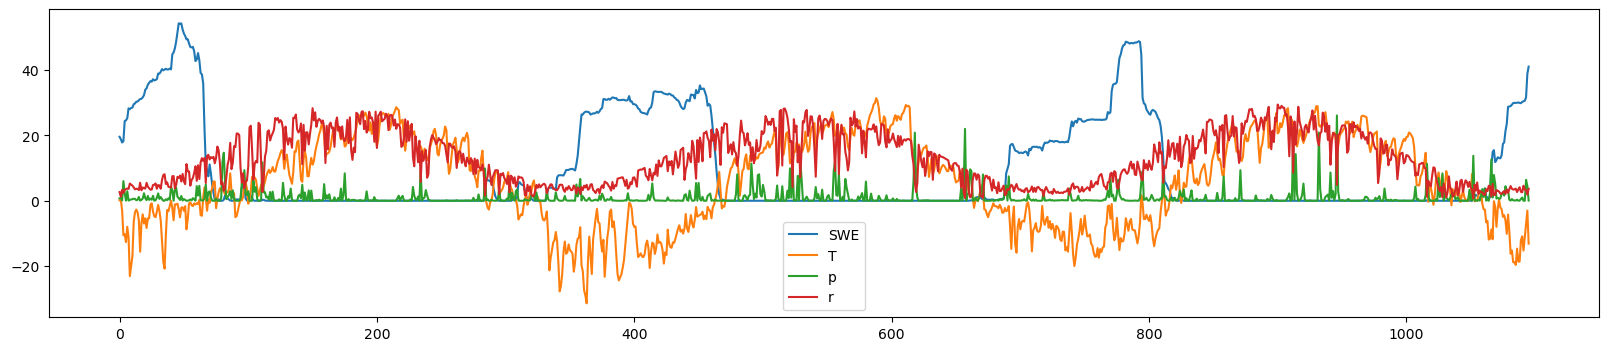

In [64]:
plt.figure(figsize=(20, 4))
plt.plot(data[0]['swe'], label='SWE')
plt.plot(data[0]['tair'], label='T')
plt.plot(data[0]['tp'], label='p')
plt.plot(data[0]['ssrd'], label='r')
plt.legend()

The shape corresponds to three years of daily values:

In [65]:
data[0]['swe'].shape

(1096,)

The PyTorch `Dataset` can now simply be passed to the PyTorch `DataLoader`, which creates minibatches and provides other useful features, such as random shuffling (without replacement):

In [67]:
data_loader = DataLoader(data, batch_size=10, shuffle=True)

A `DataLoader` is iterable, it returns whatever we defined in the `Dataset`, but stacked to batches. Each batch consistes of 10 (`batch_size`) random (`shuffle=True`) samples:

In [68]:
# We can now loop through the data_loader in chunks of size 10 (=batch_size):
for i, batch in enumerate(data_loader):
    print(batch['swe'].shape)
    if i == 5:
        break

torch.Size([10, 1096])
torch.Size([10, 1096])
torch.Size([10, 1096])
torch.Size([10, 1096])
torch.Size([10, 1096])
torch.Size([10, 1096])


## Building the hybrid model

We subclass the PyTorch `Module`. It handles things for us in the background.

* `__init__`: the python way to define object initializations. We pass all custom arguments here
    * `num_hidden`: the number of hidden nodes
    * `features` and `targets`: the variables
    * Note that the number of hidden layers is hard-coded to `1`
* `forward_loop`: the forward iteration over the time series
    * 

In [70]:
class Hybrid(torch.nn.Module):
    def __init__(
            self,
            num_hidden: int = 32,
            features: list[str] = ['tair', 'tp', 'ssrd'],
            target: str = 'swe') -> None:
        """Initialize the hybrid model.

        Args:
            num_hidden: the number of hidden nodes
            featues, targets: the variable names.
        """
        super().__init__()

        self.features = features
        self.target = target

        self.feedforward = torch.nn.Sequential(
            torch.nn.Linear(len(features) + 1, num_hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(num_hidden, num_hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(num_hidden, 2)
        )
        self.sigmoid = torch.nn.Sigmoid()
        self.softplus = torch.nn.Softplus()
        self.mse_loss = torch.nn.MSELoss()

    def forward_loop(
            self,
            batch: dict[str, Tensor],
            s_past: Tensor = None) -> tuple[Tensor, Tensor, Tensor, Tensor]:
        """Forward loop through the time series.
        
        Args:
            batch: the data batch.
            s_past: the past snow state. If not passed, the state is initialized with zeros.

        Returns:
            Tuple of four tensors:
                s, snowfall, snowmelt: the simulated time series
                s_past: the past snow state
        """


        # Grab the inputs to the neural networks.
        x = self.get_features(batch)

        # We also need air temperature and precipitation separately for the physical part.
        tair = batch['tair']
        prec = batch['tp']

        # If the initial snow state is not provided, we use zeros.
        if s_past is None:
            s_past = torch.zeros_like(prec[:, :1])

        # Initialize the snow, snowfall, and snowmelt time series.
        s = torch.zeros_like(x[..., 0])
        snowfall = torch.zeros_like(x[..., 0])
        snowmelt = torch.zeros_like(x[..., 0])

        # Here we start to loop over the time series, on index at a time.
        for t in range(x.shape[1]):

            # Get the current features.
            # x has shape (batch, sequence, features)
            # x_t has shape (batch, features)
            x_t  = x[:, t, :]

            # Add the past snow state to the current meteo inputs.
            # xs_t has shape (batch, features + 1)
            xs_t = torch.concat((x_t, s_past), dim=-1)

            # We run the data through the neural network and get two predictions (for the two values we
            # estimate, s_melt and s_fall).
            # out_t has shape (batch, 2)
            out_t = self.feedforward(xs_t)

            # Here we split the output into the two parameters.
            # Both have now shape (batch, 1).
            snowfall_fraction_t, snowmelt_t = out_t.split(split_size=1, dim=-1)

            # Snowfall fraction is first mapped to values between 0 and 1 (sigmoid activation) and then
            # multiplied with precipitation.
            # snowfall_t has shape (batch, 1).
            snowfall_t = self.sigmoid(snowfall_fraction_t) * prec[:, t:t+1]

            # Snowmelt factor is first mapped to positive values (softplus activation) and then
            # multiplied with positive air temperature. Negative air temperatures are mapped to
            # zero with the relu activation.
            # snowmelt_t has shape (batch, 1).
            snowmelt_t = self.softplus(snowmelt_t) * torch.relu(tair[:, t:t+1])

            # Here we update the snow state. Relu activation makes sure that snow cannot
            # be negative.
            # s_past has shape (batch, 1).
            s_past = torch.relu(s_past + snowfall_t - snowmelt_t)

            # We assign the predictions to the pre-initialized tensors.
            s[:, t] = s_past[:, 0]
            snowfall[:, t] = snowfall_t[:, 0]
            snowmelt[:, t] = snowmelt_t[:, 0]

        return s, snowfall, snowmelt, s_past

    def forward(self, batch: dict[str, Tensor]) -> tuple[Tensor, dict[str, Tensor]]:
        """The forward pass (required by PyTorch).DS_Store
        
        Args:
            batch: the data batch

        Returns:
            the loss and a dictionary with the results.
        """

        # We do one pass without gradients for model splin up. The returned
        # value `s_init` is the last snow state which we use as initial snow
        # state for the actual forward run.
        with torch.no_grad():
            _, _, _, s_init = self.forward_loop(batch)

        # Here we run the data through the model and record gradients (which
        # are used later to update the weights).
        s, snowfall, snowmelt, _ = self.forward_loop(batch, s_init)

        # We calculate the loss...
        loss = self.loss_fn(s, batch['swe'])

        # ...and store the results in a dictionary.
        res = {
            'swe': s.detach().cpu().numpy(),
            'snowfall': snowfall.detach().cpu().numpy(),
            'snowmelt': snowmelt.detach().cpu().numpy(),
            'latitude': batch['latitude'],
            'longitude': batch['longitude'],
        }

        return loss, res


    def get_features(self, batch: dict[str, Tensor]) -> Tensor:
        """Get the stacked feature variables from a batch."""
        return torch.stack([batch[feature] for feature in self.features], dim=-1)

    def get_target(self, batch: dict[str, Tensor]) -> Tensor:
        """Get the target variable from a batch."""
        return batch[self.target].unsqueeze(-1)

    def loss_fn(self, y_hat: Tensor, y: Tensor) -> Tensor:
        """Calculate the MSE loss."""
        return self.mse_loss(y_hat, y)


## Model training

 We can now create all the required parts to run the model:
* Training and validation data loaders
* The model
* The optimizer

In [71]:
train_loader = DataLoader(
    EraData(ds, time=slice('2000', '2015')),
    batch_size=10,
    shuffle=True
)
valid_loader = DataLoader(
    EraData(ds, time=slice('2016', '2021')),
    batch_size=10,
    shuffle=True
)

hybrid = Hybrid()

In [72]:
def train_model(
        model: torch.nn.Module,
        train_loader: torch.utils.data.DataLoader,
        valid_loader: torch.utils.data.DataLoader,
        num_epochs: int,
        inference: bool = False) -> tuple[list[str], list[str], list[dict[str, Tensor]], list[dict[str, Tensor]]]:
    """Model training loop.

    Args:
        model: the model to optimize.
        num_epochs: the number of epochs to run.
        inference: if `False`, the model is trained, else, only predictions are made.
    """

    if inference:
        num_epochs = 1
    
    # The optimizer keeps track of gradients and updates the model weights.
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0)
    train_losses = []
    valid_losses = []
    train_res = []
    valid_res = []

    # Start epoch loop.
    for epoch in range(num_epochs):

        train_loss = []
        # Set the model to training mode.
        model.train()

        # Iterate the training data. We do not use gradients (`torch.no_grad()`) if inference only.
        with torch.no_grad() if inference else nullcontext():
            # Start the data training loop.
            pbar = tqdm(train_loader, ncols=100)
            for batch in pbar:

                # We reset the model gradients from the previous iteration...
                optimizer.zero_grad()

                # ...run the data through the model...
                loss, res = model(batch)

                if not inference:
                    # ...do backpropagation (which magically works even if we did not specify how to do it)...
                    loss.backward()

                    # ...and do an update steps, i.e., we update the model weights with a tiny step.
                    optimizer.step()

                # Store the losses:
                train_loss.append(loss.item())
                train_res.append(res)

                pbar.set_description(f'train epoch {epoch + 1:3d} / {num_epochs}')
                pbar.set_postfix_str(f'loss: {np.mean(train_loss):.2f}')

        valid_loss = []
        pbar = tqdm(valid_loader, ncols=100)
        # After each traaining epoch, we want to know the validation loss. We don't need
        # gradients as we only do inference and no weight updates.
        with torch.no_grad():

            # Set the model to evaluation mode.
            model.eval()
            for batch in pbar:

                # Here we run the data through the model...
                loss, res = model(batch)

                # ...and store the losses:
                valid_loss.append(loss.item())
                valid_res.append(res)

                pbar.set_description(f'valid epoch {epoch + 1:3d} / {num_epochs}')
                pbar.set_postfix_str(f'loss: {np.mean(valid_loss):.2f}')

            # We calculate and store the epoch mean loss:
            train_losses.append(np.mean(train_loss))
            valid_losses.append(np.mean(valid_loss))

    return train_losses, valid_losses, train_res, valid_res

In [73]:
# We load trained model. Set `load_trained_model = True` to retrain the model.
load_trained_model = True

if load_trained_model:
    hybrid = torch.load('./hybrid_checkpoint.ckpt')

In [74]:
train_losses, valid_losses, train_res, valid_res = train_model(model=hybrid, train_loader=train_loader, valid_loader=valid_loader, num_epochs=5, inference=load_trained_model)
torch.save(hybrid, './hybrid_checkpoint.ckpt')

valid epoch   1 / 1: 100%|███████████████████████████| 153/153 [00:40<00:00,  3.82it/s, loss: 35.90]


In [75]:
def assign_predictions(preds, dataloader):
    for res in preds:
        batch_size = res['swe'].shape[0]
        for b in range(batch_size):
            dataloader.dataset.ds['swe_hat'].values[:, res['latitude'][b], res['longitude'][b]] = \
                res['swe'][b]
            if 'snowmelt' in res:
                dataloader.dataset.ds['snowmelt'].values[:, res['latitude'][b], res['longitude'][b]] = \
                    res['snowmelt'][b]
            if 'snowfall' in res:
                dataloader.dataset.ds['snowfall'].values[:, res['latitude'][b], res['longitude'][b]] = \
                    res['snowfall'][b]

assign_predictions(train_res, train_loader)
assign_predictions(valid_res, valid_loader)

## Evaluation

Our model is now optimized and we analyze the results.

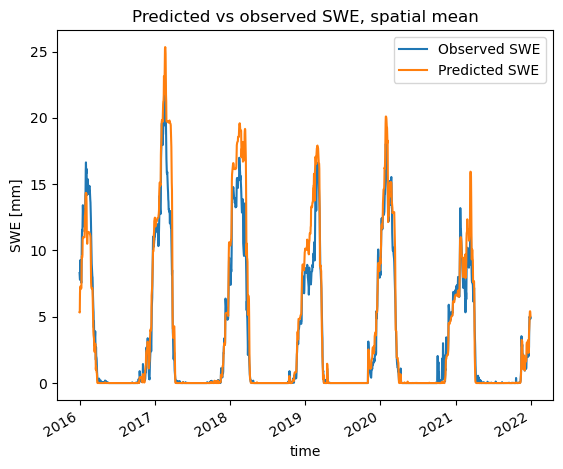

In [76]:
valid_loader.dataset.ds.swe.mean(['latitude', 'longitude']).plot(label='Observed SWE')
valid_loader.dataset.ds.swe_hat.mean(['latitude', 'longitude']).plot(label='Predicted SWE')
plt.title('Predicted vs observed SWE, spatial mean')
plt.ylabel('SWE [mm]')
plt.legend()

Text(0.5, 1.05, 'Predicted vs observed SWE, temporal mean')

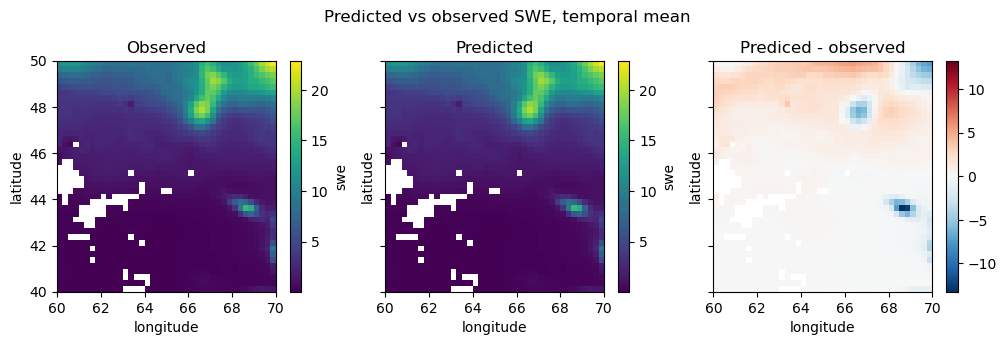

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)

for i, (data, name) in enumerate(zip(
        [
            valid_loader.dataset.ds.swe.mean('time'),
            valid_loader.dataset.ds.swe.mean('time'),
            valid_loader.dataset.ds.swe_hat.mean('time') - valid_loader.dataset.ds.swe.mean('time')
        ], [
            'Observed',
            'Predicted',
            'Prediced - observed'
        ])):
    ax = axes.flat[i]

    data.plot(ax=ax, label='')

    ax.set_title(name)

fig.suptitle('Predicted vs observed SWE, temporal mean', y=1.05)

## What did our model learn?

Text(0.5, 1.05, 'Snowfall and potential snowmelt, temporal mean')

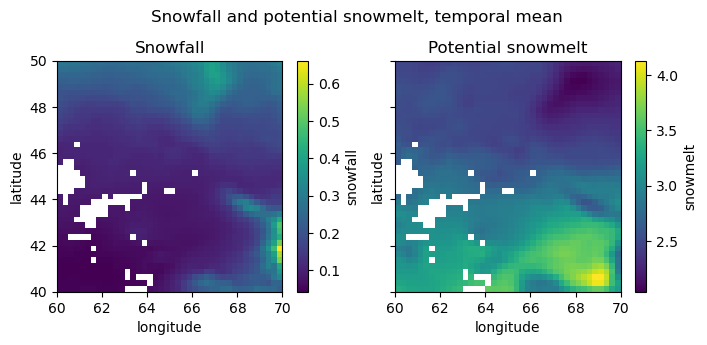

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

for i, (data, name) in enumerate(zip(
        [
            valid_loader.dataset.ds.snowfall.mean('time'),
            valid_loader.dataset.ds.snowmelt.mean('time'),
        ], [
            'Snowfall',
            'Potential snowmelt',
        ])):
    ax = axes.flat[i]

    data.plot(ax=ax)

    ax.set_title(name)

fig.suptitle('Snowfall and potential snowmelt, temporal mean', y=1.05)

### Close-up analysis for one pixel

In [79]:
ds_sel = valid_loader.dataset.ds.sel(latitude=48, longitude=68, method='nearest')

Text(0, 0.5, 'SWE [mm]')

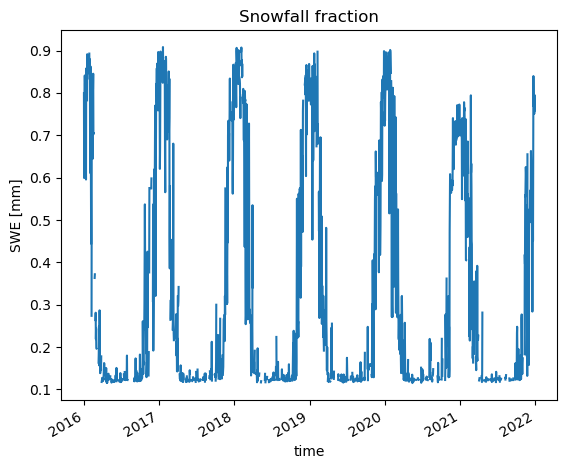

In [80]:
(ds_sel.snowfall / ds_sel.tp).plot(label='Snowfall fraction')
plt.title('Snowfall fraction')
plt.ylabel('SWE [mm]')


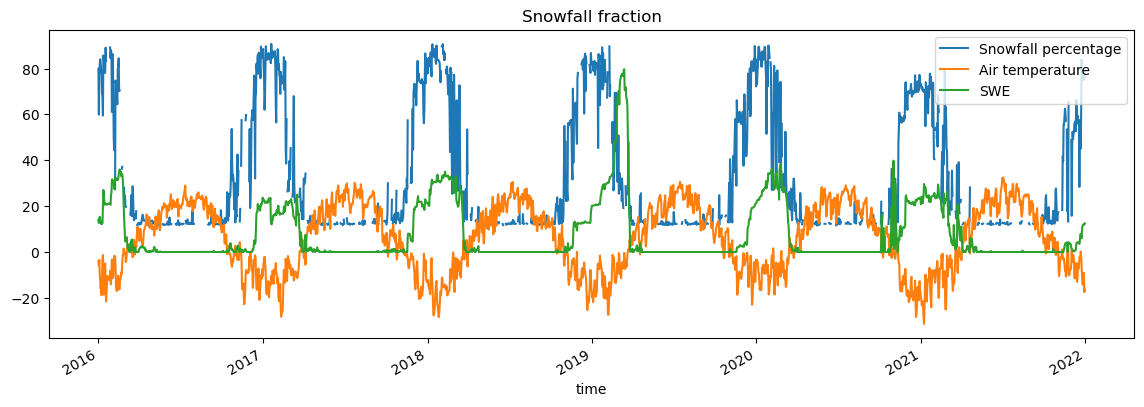

In [82]:
plt.figure(figsize=(14, 4))
(ds_sel.snowfall / ds_sel.tp * 100).plot(label='Snowfall percentage')
ds_sel.tair.plot(label='Air temperature')
ds_sel.swe.plot(label='SWE')
plt.title('Snowfall fraction')
plt.ylabel('')
plt.legend()

Note that we have ~10% of precipitation as snowfall even in summer. What went wrong?

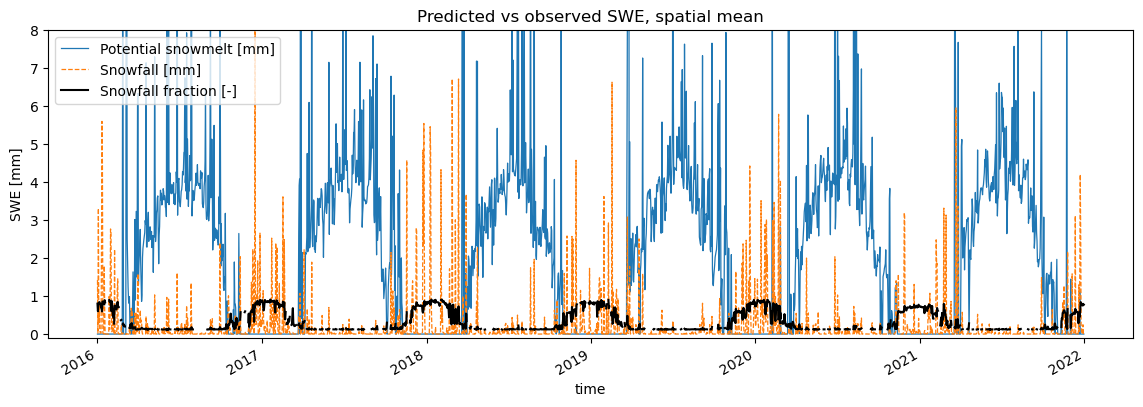

In [83]:
plt.figure(figsize=(14, 4))
ds_sel.snowmelt.plot(label='Potential snowmelt [mm]', lw=0.9)
ds_sel.snowfall.plot(label='Snowfall [mm]', lw=0.9, ls='--')
(ds_sel.snowfall / ds_sel.tp).plot(label='Snowfall fraction [-]', lw=1.5, color='k')
plt.title('Predicted vs observed SWE, spatial mean')
plt.ylim(-0.1, 8)
plt.ylabel('SWE [mm]')
plt.legend()

The model produces snow in the summer and instantly melts it away $\rightarrow$ equifinality

How can we reduce equifinality in this case? Many possibilities, for examples:
* Use air temperature in the snowfall fraction calculation (e.g., only allow snowfall fraction $\alpha_\text{fall} > 0$ if $T < 1$)
* Punish large values of snowfall and snowmelt (see next plot)
* Punish large interactions of snowfall * snowmelt (see plot after next)

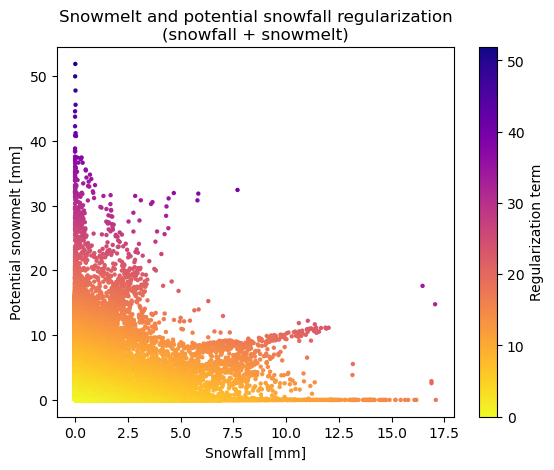

In [85]:
a = valid_loader.dataset.ds.snowfall.sel(time='2017')
b = valid_loader.dataset.ds.snowmelt.sel(time='2017')
c = a + b
plt.scatter(a, b, c=c, s=10, cmap='plasma_r', edgecolor='none')
plt.title('Snowmelt and potential snowfall regularization\n(snowfall + snowmelt)')
plt.ylabel('Potential snowmelt [mm]')
plt.xlabel('Snowfall [mm]')
plt.colorbar(label='Regularization term')

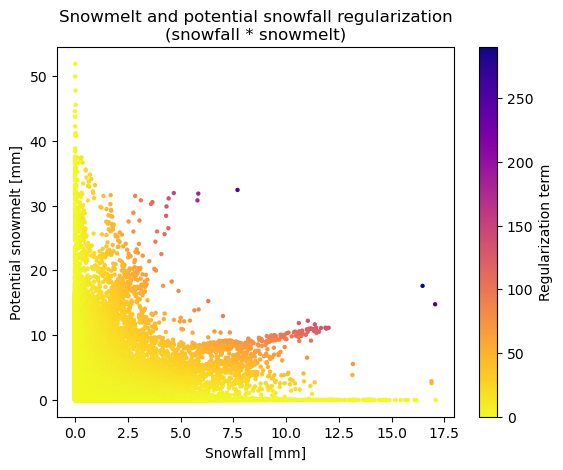

In [86]:
a = valid_loader.dataset.ds.snowfall.sel(time='2017')
b = valid_loader.dataset.ds.snowmelt.sel(time='2017')
c = a * b
plt.scatter(a, b, c=c, s=10, cmap='plasma_r', edgecolor='none')
plt.title('Snowmelt and potential snowfall regularization\n(snowfall * snowmelt)')
plt.ylabel('Potential snowmelt [mm]')
plt.xlabel('Snowfall [mm]')
plt.colorbar(label='Regularization term')

In [88]:
import torch

In [100]:
x = torch.tensor([4.**36])
for i in range(10):
    print(x)
    x *= x

tensor([4.7224e+21])
tensor([inf])
tensor([inf])
tensor([inf])
tensor([inf])
tensor([inf])
tensor([inf])
tensor([inf])
tensor([inf])
tensor([inf])


In [98]:
x

tensor([inf])

In [276]:
a = torch.Tensor([1.2])
sm = torch.Tensor([2])
sm.requires_grad = True
smax = 1
g = 1 - (sm / smax) ** a
g.retain_grad()

In [277]:
g.mean().backward()

In [282]:
sm.grad ** 300

tensor([inf])